The general idea is to use curve fitting to get V(I) from my data of current vs. voltage. From here I can calculate the power the UV is putting out. I can then calculate the energy density from the power density to compare to what is needed from the KEMLAB procedure manual. So then my ultimate goal is develop an equation that gives me exposure time as a function of current. From this equation I can then calculate the minimum time needed to get the adequate energy exposure. Even though its quite obvious that the minimum time will be at the higher current, I can still use minimization to show how python can find the minimum. So I will be using curve fitting to get V(I) and using optimization(minimization) to find the coordinates for the minimum exposure time. 

# Loading Excel File and Plotting Raw Data

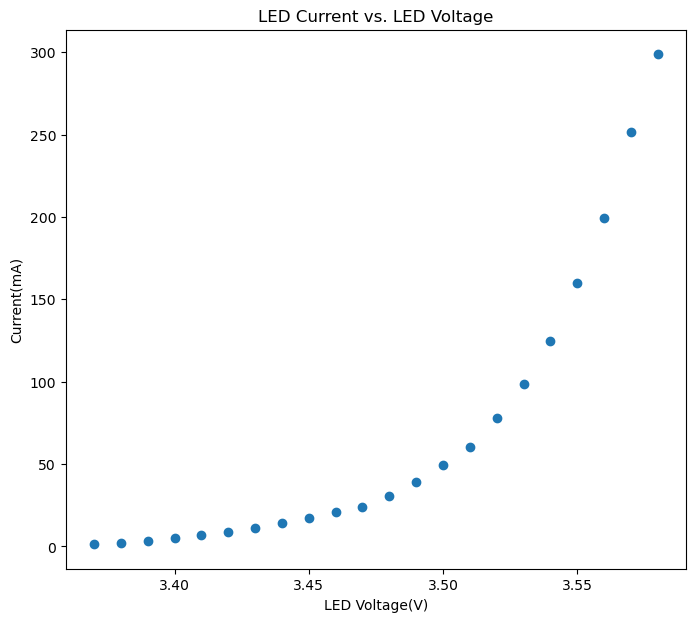

0       1.34
1       2.16
2       3.11
3       5.23
4       7.18
5       8.65
6      11.32
7      14.14
8      17.54
9      20.87
10     24.12
11     30.55
12     38.90
13     49.23
14     60.19
15     78.15
16     98.34
17    124.63
18    160.18
19    199.67
20    251.34
21    298.84
Name: LED Current(mA), dtype: float64
0     3.37
1     3.38
2     3.39
3     3.40
4     3.41
5     3.42
6     3.43
7     3.44
8     3.45
9     3.46
10    3.47
11    3.48
12    3.49
13    3.50
14    3.51
15    3.52
16    3.53
17    3.54
18    3.55
19    3.56
20    3.57
21    3.58
Name: Voltage(V), dtype: float64


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_excel("Current vs. Voltage Plots.xlsx") # My own data
V_LED=data["Voltage(V)"] # X values
I_LED=data["LED Current(mA)"] # Y values
plt.figure(figsize=(8,7))
plt.scatter(V_LED,I_LED) # Scatter Plot for raw data 
plt.title("LED Current vs. LED Voltage")
plt.xlabel("LED Voltage(V)")
plt.ylabel("Current(mA)")
plt.show()
print(I_LED)
print(V_LED)

# Current is the most important factor so invert the axes

UV Intensity is proportional to current so I want everything as aa function of current

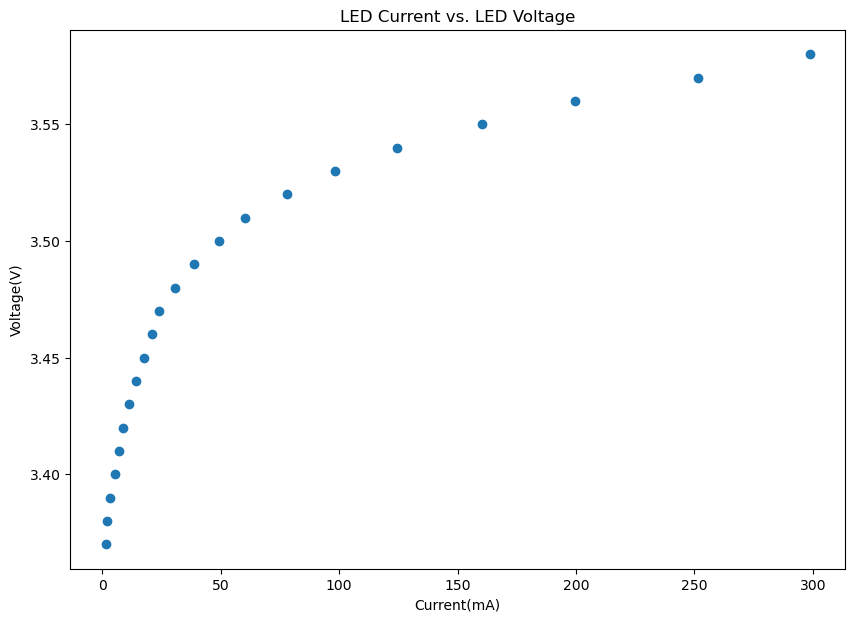

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_excel("Current vs. Voltage Plots.xlsx")
V_LED=data["Voltage(V)"] #Y values
I_LED=data["LED Current(mA)"] # X values
plt.figure(figsize=(10,7))
plt.scatter(I_LED,V_LED) # Scatter Plot for raw data 
plt.title("LED Current vs. LED Voltage")
plt.xlabel("Current(mA)")
plt.ylabel("Voltage(V)")
plt.show()

# Making a Logarithmic Fit

The logarithmic fit is V_LED = 0.0412ln(I_LED)+3.3389
The R² value for the logarithmic fit is: 0.989
The root mean squared error is: 0.007


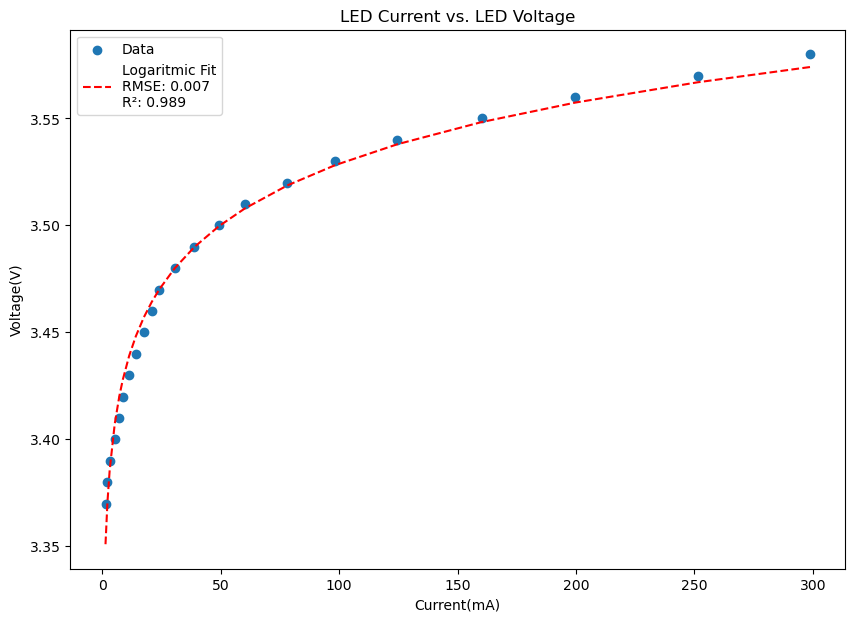

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error,r2_score
data=pd.read_excel("Current vs. Voltage Plots.xlsx")
V_LED=data["Voltage(V)"] #Y values
I_LED=data["LED Current(mA)"] # X values
def log_fit(I_LED,a,b): # Making the function for the logarithmic fit
    return a*np.log(I_LED)+b
params,_=curve_fit(log_fit,I_LED,V_LED) # Calling the curve fit function with my created function and x and y values
V_predicted=log_fit(I_LED,params[0],params[1])
r2=r2_score(V_LED,V_predicted)
rmse_ln=np.sqrt(mean_squared_error(V_LED,V_predicted))
print(f"The logarithmic fit is V_LED = {params[0]:.4f}ln(I_LED)+{params[1]:.4f}")
print(f"The R\u00b2 value for the logarithmic fit is: {r2:.3f}")
print(f"The root mean squared error is: {rmse_ln:.3f}")
plt.figure(figsize=(10,7))
plt.scatter(I_LED,V_LED,label="Data") # Scatter Plot for raw data 
plt.plot(I_LED,V_predicted,"r--",label=f"Logaritmic Fit\nRMSE: {rmse_ln:.3f}\nR\u00b2: {r2:.3f}")
plt.title("LED Current vs. LED Voltage")
plt.xlabel("Current(mA)")
plt.ylabel("Voltage(V)")
plt.legend()
plt.show()

# Calculating Power from the Logarithmic Fit

In [10]:
#P=V_LED*I_LED
def Power_calc(I_LED):
    P=(params[0]*np.log(I_LED)+params[1])*(I_LED/1000) # Voltage from logarithmic fit takes current as mA and current must be in A to get power in Watts
    return P
I_LED=float(input("Enter the current value in mA:")) # This will prompt for an input
if 0<=I_LED<=300: # Fit line is using positive current values
    P=Power_calc(I_LED)
    print(f"The Power at {I_LED:.0f} mA is: {P:.4f} W")
else:
    print("Equation is invalid for these currents")
print(f"Power as a function of current is: {params[0]/1000:.3e}I_LEDln(I_LED)+{params[1]/1000:.4e}I_LED")

Enter the current value in mA: 300


The Power at 300 mA is: 1.0723 W
Power as a function of current is: 4.125e-05I_LEDln(I_LED)+3.3389e-03I_LED


# Required UV Intensity from KEMLAB Procedure(Energy Surface Density)

According to the KEMLAB procedure for preparing SU-8, the recommended exposure dose is 60-80 mJ/cm^2. The following calculations will be based on this exposure dose range.

# Estimating the Area of the UV Beam spot

The angle of the beam from the UV source is 60 degrees. In our experimental setup, we have the UV source at different heights above the sample. So to calculate the area of the UV beam spot, I will be using trigonometry to find the radius of the spot to then find the area.

In [12]:
# Angle of beam: 60 degrees
# Create a right triangle by cutting the UV cone in half. This creates an right triangle with a top angle of 30 degrees and a height of 2.54 cm.
# tan(30)=radius/2.54
Height=float(input("Enter the height above the sample in inches:"))
angle=float(input("Enter the beam angle:"))
import numpy as np
radius=2.54*Height*np.tan((angle/2)*np.pi/180) # Defaults to radians so I will convert 
Area=np.pi*radius**2
print(f"The area of the UV beam spot is: {Area:.4f} cm\u00b2")

Enter the height above the sample in inches: 1
Enter the beam angle: 60


The area of the UV beam spot is: 6.7561 cm²


# Calculating the UV Dose from the Power after 10 minutes

Initially we were not sure how long we would need to expose the sample to UV. A safe guess was that 10 minutes(600 sec) at 1 inch above would be enough. So I will calculate what this initial UV dose is and compare it to the recommended dose of 60-80 mJ/cm^2.

In [29]:
Power_density=P/Area # Units of W/cm^2
# 1 Watt = 1 J/s
# 1 J/s = 1000 mJ/s
# So 1 W/cm^2 = 1000 mJ/(cm^2*s)
UV_Intensity=Power_density*1*1000 # Converting units from W/cm^2 to J/cm^2*s to mJ/cm^2*s in order to find UV Intensity
# UV Dose = UV Intensity*time
time=float(input("Enter the exposure time in seconds:"))# UV exposed for 10 minutes(600 seconds)
UV_Dose=UV_Intensity*time # Formula for UV Dose
print(f"UV intensity is: {UV_Intensity:.4f} mJ/cm\u00b2*s")
print(f"UV Dose after {time:.0f} seconds is: {UV_Dose:.2f} mJ/cm\u00b2")
ratio=UV_Dose/80 # Want to show how much bigger or smaller the UV Dose after 10 minutes is compared to the recommended dose
if UV_Dose>80:
    print(f"UV Dose is {ratio:.1f} times higher than neccessary after 10 minutes of exposure")
elif UV_Dose==80:
    print("UV Dose is exactly what was recommended after 10 minutes of exposure")
else:
    print(f"UV Dose is {1/ratio:.1f} times lower than neccessary after 10 minutes of exposure")

Enter the exposure time in seconds: 600


UV intensity is: 158.7087 mJ/cm²*s
UV Dose after 600 seconds is: 95225.25 mJ/cm²
UV Dose is 1190.3 times higher than neccessary after 10 minutes of exposure


# Finding UV Intensity as a function of current

Now I must redo the previous process, but using the power as a function of current. P=V(I)*I/1000. Then divide by the area and convert the units to get this function.

In [31]:
# P=V_LED*(I_LED/1000)
# V_LED=0.0412*ln(I_LED)+3.1389
# P(I)=(0.0412*ln(I_lED)+3.1389)*(I_LED/1000) function of power in terms of current in W
# P(I)=4.12e-5*I_LED*ln(I_LED)+3.1389e-3*I_LED in W 
# P(I)=0.0412*I_LED*ln(I_LED)+3.1389*I_LED in mW which is equivalent to mJ/s
# UV Intensity = P(I)/Area= (.0412*I_LED*ln(I_LED)+3.3389*I_LED)/Area. Will assign 0.0412 as a and 3.3389 as b 
a=params[0]/Area
b=params[1]/Area
print(f"UV Intensity in terms of current is: {a:.3e}I*ln(I)+{b:.4f}I")

UV Intensity in terms of current is: 6.105e-03I*ln(I)+0.4942I


# Expression for Exposure Time in terms of Current

In [33]:
#UV Intensity*time=UV Dose
#time=UV Dose/UV Intensity
UV_Dose=float(input("Enter the required UV Dose in mJ/cm\u00b2:"))
print(f"Exposure Time as a function of current is: {UV_Dose:.0f}/({a:.3e}I*ln(I)+{b:.4f}I)")

Enter the required UV Dose in mJ/cm²: 80


Exposure Time as a function of current is: 80/(6.105e-03I*ln(I)+0.4942I)


# Plotting Exposure Time and finding minimum time

The minimum exposure time is at I = 300.0 mA, and is: 0.504 seconds


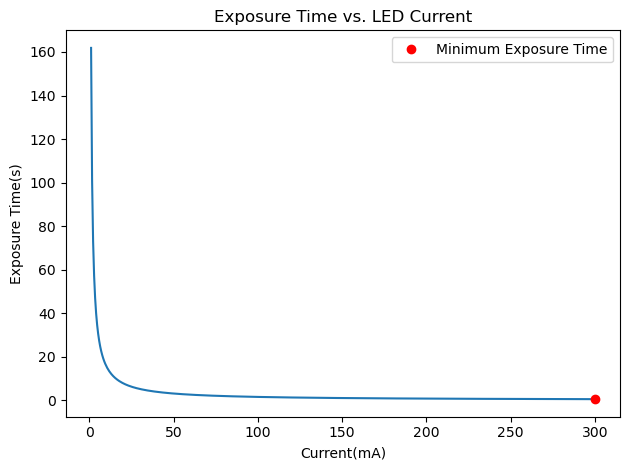

In [35]:
from scipy.optimize import minimize_scalar
def Exposure_Time(I_LED): # Defining a function so I can use the minimize scalar function
    return UV_Dose/(a*I_LED*np.log(I_LED)+b*I_LED) # Exposure Time Formula
I_LED=np.linspace(1,300,500) # Creating values of current to plug into the exposure time formula. Starting from 1 to avoid getting ln(0)
result=minimize_scalar(Exposure_Time,bounds=(0,300),method="bounded") # Storing the values into result
print(f"The minimum exposure time is at I = {result.x:.1f} mA, and is: {result.fun:.3f} seconds")
plt.plot(I_LED,Exposure_Time(I_LED)) # Plot of my created current values and the predicted exposure Time
plt.plot(result.x,result.fun,"ro",label="Minimum Exposure Time") # Indicating where on the graph the minimum is.
plt.title("Exposure Time vs. LED Current")
plt.xlabel("Current(mA)")
plt.ylabel("Exposure Time(s)")
plt.tight_layout() # Makes nice spacing 
plt.legend()
plt.show()

# Accounting for Wall Plug-in Efficiency(WPE) & Absorbance

WPE is the ratio of optical output from the LED to the electrical power input. Some of the power is lost to heat, some of the light produced is absorbed by other components of the LED chip, and some of the electron-hole pairs created . Typical light extraction efficiencies(η) for UV A LEDs(320 to 400 nm) without anything done to improve it are about 30 to 40%. The absorbance is how much of the light is actually absorbed by the photoresist and the rest is transmitted. This would affect my calculations because 40% efficiency means that only 40% of the input power is being converted to light. Also an absorbance of less that 1, will mean that a certain percentage of the light hitting the sample passes through it. To account for this, all I must do is to add the η term and the absorbance term(approximately .075 according to manufacturer) into the exposure time equation by multiplying it to the UV Intensity.

Enter the light extraction efficiency: .3
Enter the absorbance of photoresist at 360 nm UV light: .075


The minimum exposure time is when I = 300.0 mA, and is 22.40 seconds at 30% efficiency


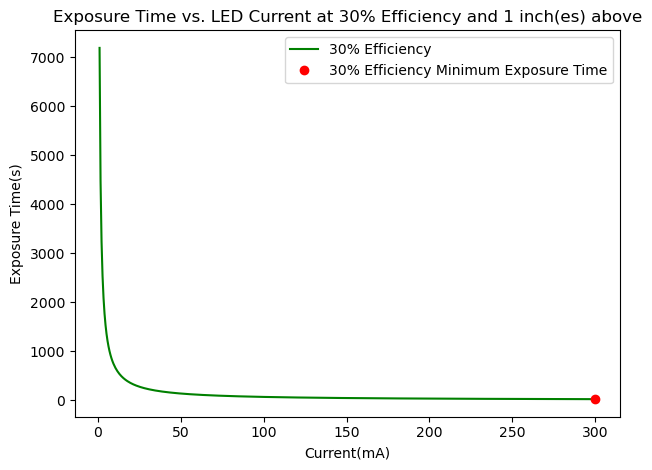

In [37]:
def η_Exposure_Time(I_LED): # Defining a function so I can use the minimize scalar function
    return UV_Dose/(𝛼*η*(a*I_LED*np.log(I_LED)+b*I_LED)) # Exposure Time Formula when accounting for Light Extraction Efficiency and absorbance
I_LED=np.linspace(1,300,500) # Creating values of current to plug into the exposure time formula
η=float(input("Enter the light extraction efficiency:")) # Prompts user to enter the efficiency
𝛼=float(input("Enter the absorbance of photoresist at 360 nm UV light:")) # Prompts user to enter the absorbance
if 0<=η<=1 and 0<=𝛼<=1:
    η_result=minimize_scalar(η_Exposure_Time,bounds=(0,300),method="bounded") # Storing the values into result
    print(f"The minimum exposure time is when I = {η_result.x:.1f} mA, and is {η_result.fun:.2f} seconds at {100*η:.0f}% efficiency")
    plt.plot(I_LED,η_Exposure_Time(I_LED),"g-",label=f"{100*η:.0f}% Efficiency") # Plot of my created current values and the predicted exposure Time
    plt.plot(η_result.x,η_result.fun,"ro",label=f"{100*η:.0f}% Efficiency Minimum Exposure Time") # Indicating where on the graph the minimum is.
    plt.title(f"Exposure Time vs. LED Current at {100*η:.0f}% Efficiency and {Height:.0f} inch(es) above")
    plt.xlabel("Current(mA)")
    plt.ylabel("Exposure Time(s)")
    plt.tight_layout() # Makes nice spacing 
    plt.legend()
    plt.show() 
else:
    print("Enter a number between 0 and 1 for WPE and absorbance") 